In [1]:
# Import libraries and packages

import warnings

warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import io
import os
from sklearn import metrics
from sklearn.utils import shuffle

In [3]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Add, Input, Dropout, Activation, BatchNormalization, ZeroPadding2D, AveragePooling2D)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2, ResNet50
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback

%matplotlib inline

# Data Augmentation

In [4]:
#for train set
train_dir = 'B:/Project PG/E+A+D/'

#for validation set
eyepacs_gt = pd.read_csv(r"B:\Project PG\trainLabels_eyepac.csv")
eyepacs_gt = eyepacs_gt.rename(columns = {"level":"grade"})
eyepacs_gt['path'] = 'B:/Project PG/ZIPS/eyepacs_preprocess/eyepacs_preprocess/'
eyepacs_gt['ext'] = ".jpeg"
eyepacs_gt['image_path'] = eyepacs_gt['path'].astype(str) + eyepacs_gt['image'].astype(str)+eyepacs_gt['ext'].astype(str)
eyepacs_gt = eyepacs_gt[['image_path', 'grade']]


# Set up the data augmentation parameters for the training set
train_datagen = ImageDataGenerator(rescale = 1.0 /255.0,
                                   rotation_range = 20,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=0.2,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  fill_mode = 'nearest')
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
    
# Set the batch size
batch_size = 32

# Set the input image size
image_size = (224, 224)  # Adjust according to your requirements

# Create the train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse'
)

# Create the validation generator
validation_generator = train_datagen.flow_from_dataframe(
    eyepacs_gt, x_col='image_path', y_col='grade',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='raw')

Found 40792 images belonging to 5 classes.
Found 35108 validated image filenames.


# Model Building and Training

In [5]:
opt = Adam(lr=0.0001)

In [6]:
def create_model(base_model):
    base_model.trainable = True
    global_average_layer = GlobalAveragePooling2D()(base_model.output)
    prediction_layer = Dense(5, activation='softmax')(global_average_layer)
    model = Model(inputs=base_model.input, outputs=prediction_layer)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=["accuracy"])
    return model

In [7]:
batch_size = 64
epochs = 120
def fit_model(model):
    history = model.fit_generator(train_generator,
                      steps_per_epoch=len(train_generator)//batch_size, 
                        epochs=epochs, 
                        validation_data=(validation_generator), 
                        validation_steps=len(validation_generator)//batch_size)
    return history

In [8]:
def create_model2(base_model):
    # Freeze the base model's layers
    base_model.trainable = False

    # Add custom classification layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Training Inception V3

In [14]:
IMG_SHAPE = (224, 224, 3)
inception_v3 = InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
inc_v3 = create_model(inception_v3)
incv3_history = fit_model(inc_v3)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/120
12/12 [==============================] - 223s 19s/step - loss: 1.3240 - acc: 0.5104 - val_loss: 2.4566 - val_acc: 0.7188
Epoch 2/120
12/12 [==============================] - 185s 15s/step - loss: 0.9232 - acc: 0.7344 - val_loss: 3.3776 - val_acc: 0.7188
Epoch 3/120
12/12 [==============================] - 185s 15s/step - loss: 0.8224 - acc: 0.7578 - val_loss: 2.7375 - val_acc: 0.7188
Epoch 4/120
12/12 [==============================] - 185s 15s/step - loss: 0.9336 - acc: 0.6979 - val_loss: 1.9398 - val_acc: 0.7188
Epoch 5/120
12/12 [==============================] - 184s 15s/step - loss: 0.7935 - acc: 0.7604 - val_loss: 2.1288 - val_acc: 0.7188
Epoch 6/120
12/12 [==============================] - 185s 15s/step - loss: 0.8420 - acc: 0.7500 - val_loss: 1.9317 - val_acc: 0.7188
Epoch 7/120
12/12 [==============================] - 189s 16s/step - loss: 0.8707 - 

12/12 [==============================] - 182s 15s/step - loss: 0.5801 - acc: 0.7995 - val_loss: 0.8171 - val_acc: 0.7625


# Traing InceptionV2-Resnet

In [17]:
IMG_SHAPE = (224, 224, 3)
InceptionV2_Resnet = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights="imagenet")
incv2_renet = create_model2(InceptionV2_Resnet)
incv2res_history = fit_model(incv2_renet)

Epoch 1/120
12/12 [==============================] - 154s 13s/step - loss: 1.2033 - acc: 0.6641 - val_loss: 1.3508 - val_acc: 0.7188
Epoch 2/120
12/12 [==============================] - 139s 12s/step - loss: 0.9744 - acc: 0.7266 - val_loss: 1.7576 - val_acc: 0.7188
Epoch 3/120
12/12 [==============================] - 141s 12s/step - loss: 0.9300 - acc: 0.7318 - val_loss: 1.9098 - val_acc: 0.7188
Epoch 4/120
12/12 [==============================] - 140s 12s/step - loss: 0.7987 - acc: 0.7630 - val_loss: 1.8395 - val_acc: 0.7188
Epoch 5/120
12/12 [==============================] - 139s 12s/step - loss: 0.8610 - acc: 0.7396 - val_loss: 1.9591 - val_acc: 0.7188
Epoch 6/120
12/12 [==============================] - 140s 12s/step - loss: 0.8367 - acc: 0.7422 - val_loss: 1.6311 - val_acc: 0.7188
Epoch 7/120
12/12 [==============================] - 140s 12s/step - loss: 0.8980 - acc: 0.7578 - val_loss: 1.5615 - val_acc: 0.7188
Epoch 8/120
12/12 [==============================] - 140s 12s/step - 

# Ensemble All Model

In [109]:
# Freeze the layers of both models
for layer in inc_v3.layers:
    layer.trainable = False

for layer in incv2_renet.layers:
    layer.trainable = False
    
# Define input shape for the models
input_shape = (224, 224, 3)
inceptionv3_input = Input(shape=input_shape)
inceptionresnetv2_input = Input(shape=input_shape)

# Get the output tensors of the models
inceptionv3_output = inception_v3(inceptionv3_input)
inceptionv3_output = GlobalAveragePooling2D()(inceptionv3_output)                     

inceptionresnetv2_output = InceptionV2_Resnet(inceptionresnetv2_input)
inceptionresnetv2_output = GlobalAveragePooling2D()(inceptionresnetv2_output)

# Concatenate the outputs of the models
                                              
merged_output = concatenate([inceptionv3_output,inceptionresnetv2_output])

# Add additional layers for classification
x = Dense(512, activation='relu')(merged_output)
x = Dropout(0.5)(x)  # Dropout for regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.)(x)  # Dropout for regularization
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x)  

# Create the ensemble model
ensemble_model = Model(inputs=[inceptionv3_input, inceptionresnetv2_input], outputs=output)

# Compile the ensemble model
ensemble_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the ensemble model
ensemble_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_32[0][0]                   
__________________________________________________________________________________________________
inception_resnet_v2 (Model)     (None, 5, 5, 1536)   54336736    input_33[0][0]                   
____________________________________________________________________________________________

In [21]:
def combined_generator(generator1, generator2):
    while True:
        batch_X1, batch_y1 = generator1.next()
        batch_X2, batch_y2 = generator2.next()
        yield [batch_X1, batch_X2], batch_y1  # Yield both batches and the labels

In [23]:
batch = 2750
# Train the ensemble model using fit_generator
ens_history = ensemble_model.fit_generator(
    combined_generator(train_generator, train_generator),
    steps_per_epoch=train_generator.samples // batch,
    epochs=39,
    validation_data=combined_generator(validation_generator,validation_generator),
    validation_steps=validation_generator.samples // batch)

Epoch 1/39
8/8 [==============================] - 147s 18s/step - loss: 0.5220 - acc: 0.8438 - val_loss: 0.7863 - val_acc: 0.7812
Epoch 2/39
8/8 [==============================] - 144s 18s/step - loss: 0.5223 - acc: 0.8359 - val_loss: 0.7099 - val_acc: 0.8125
Epoch 3/39
8/8 [==============================] - 144s 18s/step - loss: 0.6038 - acc: 0.7891 - val_loss: 0.8384 - val_acc: 0.7500
Epoch 4/39
8/8 [==============================] - 143s 18s/step - loss: 0.5208 - acc: 0.8242 - val_loss: 0.9026 - val_acc: 0.7396
Epoch 5/39
8/8 [==============================] - 142s 18s/step - loss: 0.4600 - acc: 0.8711 - val_loss: 0.6794 - val_acc: 0.8021
Epoch 6/39
8/8 [==============================] - 143s 18s/step - loss: 0.4663 - acc: 0.8594 - val_loss: 0.6803 - val_acc: 0.8021
Epoch 7/39
8/8 [==============================] - 143s 18s/step - loss: 0.6157 - acc: 0.7812 - val_loss: 0.5839 - val_acc: 0.8333
Epoch 8/39
8/8 [==============================] - 143s 18s/step - loss: 0.6134 - acc: 0.80

# Average Training Accuracy

In [24]:
np.mean(ens_history.history['acc'])

0.83071614


In [29]:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    
    ax[0].legend()
    ax[1].legend()

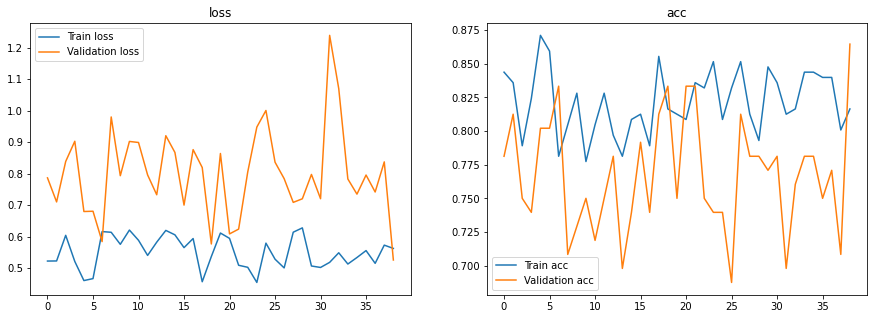

In [30]:
show_history(ens_history)

# Accuracy On train_generator

In [120]:
score = ensemble_model.evaluate(combined_generator(train_generator, train_generator),steps=5)
print('Test score:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 138s 28s/step - loss: 0.6283 - acc: 0.7937
Test score: 0.6282689452171326
Test accuracy: 0.79375


# Accuracy On validation_generator

In [121]:
score = ensemble_model.evaluate(combined_generator(validation_generator, validation_generator),steps=5)
print('Test score:', score[0])
print('Test accuracy:', score[1])

5/5 [==============================] - 156s 31s/step - loss: 0.6186 - acc: 0.8188
Test score: 0.6186415433883667
Test accuracy: 0.81875


# Evaluate The Model Using A External Dataset

In [124]:
import os
import cv2
import numpy as np

#Path To Images
image_folder = "B:/Project PG/B. Disease Grading/B. Disease Grading/1. Original Images/a. Training Set/"
#Path to csv file containing actual classes 
df = pd.read_csv(r"B:\Project PG\B. Disease Grading\B. Disease Grading\2. Groundtruths\a. IDRiD_Disease Grading_Training Labels.csv")
act_cls = df[['Retinopathy grade']] #Actual classes

predicted_classes = []

# Iterate through the images
for filename in os.listdir(image_folder):
    # Load and preprocess the image
    image_path = os.path.join(image_folder, filename)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (224, 224))  # Resize image to match the model's input size
    image = image / 255.0  # Normalize pixel values between 0 and 1
    image = np.reshape(image, (1, 224, 224, 3))

    # Make prediction
    prediction = ensemble_model.predict([image,image])
    predicted_class = np.argmax(prediction)
    predicted_classes.append(predicted_class)

In [132]:
from sklearn.metrics import classification_report
print(classification_report(act_cls, predicted_classes))

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       134
           1       0.69      0.87      0.77        60
           2       0.88      0.83      0.86       136
           3       0.74      0.70      0.72        74
           4       0.70      0.90      0.79        49

    accuracy                           0.81       453
   macro avg       0.78      0.82      0.79       453
weighted avg       0.82      0.81      0.81       453



<AxesSubplot:>

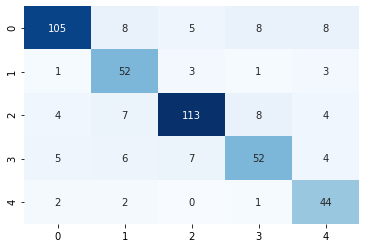

In [133]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_mat = confusion_matrix(act_cls, predicted_classes)
sns.heatmap(confusion_mat, annot=True, fmt="d", cbar=False, cmap=plt.cm.Blues, vmax=confusion_mat.max())